# I. Load libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

In [2]:
heart = pd.read_csv('heart_new.csv', index_col=0)
heart.drop(columns='ST_depression_bins', inplace=True)
heart.head()

,age,sex,pain_type,restingBP,chol,fasting_sugar,resting_ecg,maxHR,exercise_angina,ST_depression,ST_peak_slope,vessels_fluoro,thal_severity,heart_disease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# II: Modeling

## Nearest Neighbors Classification

In [3]:
from sklearn.neighbors import KNeighborsClassifier

X = heart.drop(columns='heart_disease')
y = heart['heart_disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print("3 Nearest Neighbors Accuracy Score (Class.): ", knn.score(X_test, y_test))

3 Nearest Neighbors Accuracy Score (Class.):  0.6081081081081081


## Decision Tree Classifier & Visualization

In [4]:
from sklearn.tree import DecisionTreeClassifier

features = heart.drop(columns='heart_disease')
target = heart.heart_disease

# Create classifier object
dtree = DecisionTreeClassifier(random_state=0)

# Train
model = dtree.fit(features, target)

In [5]:
# Viasualize
import pydotplus
from IPython.display import Image
from sklearn import tree

# Create DOT data
dot_data = tree.export_graphviz(dtree, feature_names=heart.drop(columns='heart_disease').columns.values, class_names="01")

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Save graph
graph.write_png("decision_tree.png")

True

![Decision Tree Visualization](decision_tree.png)

## Random Forest Classification

In [6]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(n_estimators = 1000, random_state = 1)
randomforest.fit(X_train, y_train)

acc = randomforest.score(X_test, y_test)

print("Random Forest Accuracy Score: ", acc)

Random Forest Accuracy Score:  0.7567567567567568


### Identifying important features of Random Forest model

C:\Users\lilli\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


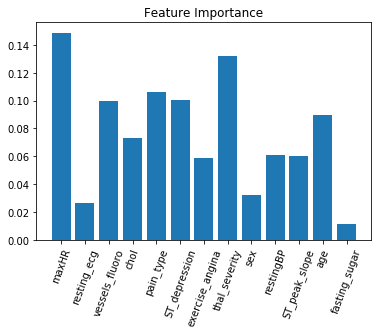

In [7]:
features = heart.drop(columns='heart_disease')
target = heart.heart_disease

randomforest = RandomForestClassifier(random_state=0, n_jobs=-1)

model = randomforest.fit(features, target)

# Calculate importances
importances = model.feature_importances_

# Sort importances in descending order
indices = np.argsort(importances[::-1])

# Rearrange features so they match the sorted features
names = [heart.columns[i] for i in indices]

# Plot
plt.figure()
plt.title("Feature Importance")
plt.bar(range(features.shape[1]), importances[indices])
plt.xticks(range(features.shape[1]), names, rotation=70)
plt.show()

### Retraining the model based on the most important features

In [8]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(randomforest, threshold=.12)

features_important = selector.fit_transform(features, target)

model = randomforest.fit(features_important, target)

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

X = heart.drop(columns='heart_disease')
y = heart.heart_disease

X_train, X_test, y_train, y_test = train_test_split(X, y)

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg.score(X_test, y_test)

C:\Users\lilli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8243243243243243

# III. Feature Engineering

## Create new feature based on those with higher than average maximum heart rates [(AHA)](https://www.heart.org/en/healthy-living/fitness/fitness-basics/target-heart-rates)

In [10]:
# The American Heart Associated defines higher than avgerage heart rate as any heart rate greater than 220 minus one's age

# Create a list of rows containing only those with higher than average maximum heart rates
def maxHR_above_avg():
    above_avg = []
    
    for index, row in heart.iterrows():
        if (220 - row['age'] < row['maxHR']):
            above_avg.append(1)
        else:
            above_avg.append(0)
    
    return above_avg

# Create a new column in heart dataframe
heart['maxHR_above_avg'] = maxHR_above_avg()

heart.head()

,age,sex,pain_type,restingBP,chol,fasting_sugar,resting_ecg,maxHR,exercise_angina,ST_depression,ST_peak_slope,vessels_fluoro,thal_severity,heart_disease,maxHR_above_avg
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,0


# IV. Modeling II

## Updated Decision Tree Visualization

In [12]:
features = heart.drop(columns='heart_disease')
target = heart.heart_disease

# Create classifier object
dtree = DecisionTreeClassifier(random_state=0)

# Train
model = dtree.fit(features, target)

# Viasualize
import pydotplus
from IPython.display import Image
from sklearn import tree

# Create DOT data
dot_data = tree.export_graphviz(dtree, feature_names=heart.drop(columns='heart_disease').columns.values, class_names="01")

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Save graph
graph.write_png("updated_decision_tree.png")

True

## Updated Logistic Regression Score

In [16]:
from sklearn.linear_model import LogisticRegression

X = heart.drop(columns='heart_disease')
y = heart.heart_disease

X_train, X_test, y_train, y_test = train_test_split(X, y)

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg.score(X_test, y_test)

C:\Users\lilli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8513513513513513